# Stock Price and Sentiment Analysis with LSTM

This notebook performs stock price prediction using LSTM by combining stock data from Yahoo Finance and sentiment analysis from news data using the FinBERT model.


## Step 1: Import Libraries

We begin by importing necessary libraries for data handling, fetching, sentiment analysis, scaling, and modeling.


In [1]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
import finnhub
from datetime import datetime, timedelta
from transformers import pipeline, AutoTokenizer
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt


## Step 2: Fetch Stock Data

In this step, we define a function to fetch historical stock data for a given ticker symbol from Yahoo Finance. The function takes the ticker symbol, start date, and end date as inputs and returns the stock data.


In [2]:
def fetch_stock_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)


## Step 3: Fetch Sentiment Data

Here, we define a function to fetch sentiment data for the specified company using the Finnhub API. The function loops over the date range, fetching news articles in two-day increments, and returns a DataFrame of news articles with timestamps.


In [3]:
def fetch_sentiment_data(company, start_date, end_date, finnhub_client):
    all_data = []
    current_date = start_date
    api_call_count = 0
    
    while current_date < end_date:
        next_date = current_date + timedelta(days=2)
        _from = current_date.strftime('%Y-%m-%d')
        _to = next_date.strftime('%Y-%m-%d')
        
        data = finnhub_client.company_news(company, _from=_from, to=_to)
        all_data.extend(data)
        api_call_count += 1
        
        if api_call_count >= 60:
            print("API call limit reached. Waiting for 61 seconds...")
            time.sleep(61)
            api_call_count = 0
        
        current_date = next_date
    
    df = pd.DataFrame(all_data)
    df['timestamp'] = pd.to_datetime(df['datetime'], unit='s')
    df = df.sort_values(by='timestamp')
    return df


## Step 4: Perform Sentiment Analysis

In this step, we perform sentiment analysis on the news articles using the FinBERT model. The sentiment analysis results are then converted into sentiment scores, which are added to the DataFrame.


In [4]:
def perform_sentiment_analysis(df):
    sentiment_model = pipeline('sentiment-analysis', model="ProsusAI/finbert")
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    
    def truncate_and_analyze(text):
        tokens = tokenizer(text, truncation=True, max_length=512, return_tensors='pt')
        truncated_text = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
        return sentiment_model(truncated_text)[0]['label']
    
    df['sentiment'] = df['summary'].apply(truncate_and_analyze)
    label_to_score = {'positive': 1, 'neutral': 0, 'negative': -1}
    df['sentiment_score'] = df['sentiment'].map(label_to_score)
    df['date'] = df['timestamp'].dt.date
    return df


## Step 5: Combine Stock and Sentiment Data

We combine the stock data with the sentiment data by aligning the sentiment scores with the trading days. This step includes shifting sentiment scores from non-trading days to the next trading day and merging the datasets.


In [5]:
def combine_stock_and_sentiment(stock_data, sentiment_data):
    trading_days = pd.to_datetime(stock_data.index).date
    
    def shift_to_next_trading_day(row):
        if row['date'] not in trading_days:
            future_trading_days = [day for day in trading_days if day > row['date']]
            if future_trading_days:
                return future_trading_days[0]
        return row['date']
    
    sentiment_data['adjusted_date'] = sentiment_data.apply(shift_to_next_trading_day, axis=1)
    daily_sentiment = sentiment_data.groupby('adjusted_date')['sentiment_score'].mean().reset_index()
    daily_sentiment.rename(columns={'adjusted_date': 'date'}, inplace=True)
    
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    
    combined_data = pd.merge(stock_data, daily_sentiment, left_on='Date', right_on='date', how='left')
    combined_data.drop(columns=['date'], inplace=True)
    return combined_data


## Step 6: Scale Features

To prepare the data for modeling, we scale the stock features and sentiment scores using MinMaxScaler. We also calculate moving averages and drop any rows with missing values due to the moving average calculation.


In [6]:
def scale_features(combined_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score']] = scaler.fit_transform(
        combined_data[['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score']])
    
    combined_data['ma5'] = combined_data['Close'].rolling(window=5).mean()
    combined_data['ma10'] = combined_data['Close'].rolling(window=10).mean()
    combined_data.dropna(inplace=True)
    
    return combined_data

## Step 7: Prepare Data for LSTM

This section prepares the data for the LSTM model by defining the features and target variable. We split the data into training and testing sets and reshape it into a 3D array required by the LSTM model.


In [7]:
def prepare_lstm_data(combined_data):
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score', 'ma5', 'ma10']
    target = 'Close'
    
    X = combined_data[features].values
    y = combined_data[target].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train, X_test, y_train, y_test


## Step 8: Build and Train LSTM Model

In this step, we define a function to build and train an LSTM model using Keras and Keras Tuner for hyperparameter optimization. The function returns the best model based on validation loss.


In [8]:
def build_and_train_lstm(X_train, y_train, X_test, y_test):
    def build_model(hp):
        model = Sequential()
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=50, max_value=200, step=50),
                           return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(hp.Float('dropout_' + str(i), 0.1, 0.5, step=0.1)))
        model.add(Dense(1))
        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
        return model
    
    tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, executions_per_trial=2,
                         directory='my_dir', project_name='lstm_hpo')
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_model, tuner

## Step 9: Evaluate and Plot

Finally, we evaluate the performance of the best model and plot the predicted stock prices against the actual prices. This section also summarizes the results of the hyperparameter optimization process.


In [9]:
def evaluate_and_plot(best_model, X_test, y_test, combined_data):
    predicted_stock_price = best_model.predict(X_test)
    test_dates = combined_data.iloc[-len(y_test):]['Date'].values
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, color='red', label='Actual Stock Price')
    plt.plot(test_dates, predicted_stock_price, color='blue', label='Predicted Stock Price')
    plt.title('Stock Price Prediction (Best Model)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
    results = tuner.get_best_hyperparameters(num_trials=10)
    performance_data = []
    
    for i, result in enumerate(results):
        model = tuner.hypermodel.build(result)
        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
        val_loss = history.history['val_loss'][-1]
        performance_data.append({'Trial': i + 1, 'Hyperparameters': result.values, 'Validation Loss': val_loss})
    
    performance_df = pd.DataFrame(performance_data)
    performance_df = performance_df.sort_values(by='Validation Loss')
    return performance_df


## Step 10: Main Execution Block

This section brings together all the functions defined above and executes the workflow from data fetching to model evaluation and plotting.


Trial 10 Complete [00h 00m 10s]
val_loss: 0.004369762376882136

Best val_loss So Far: 0.000647871580440551
Total elapsed time: 00h 01m 15s
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/Users/selim/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


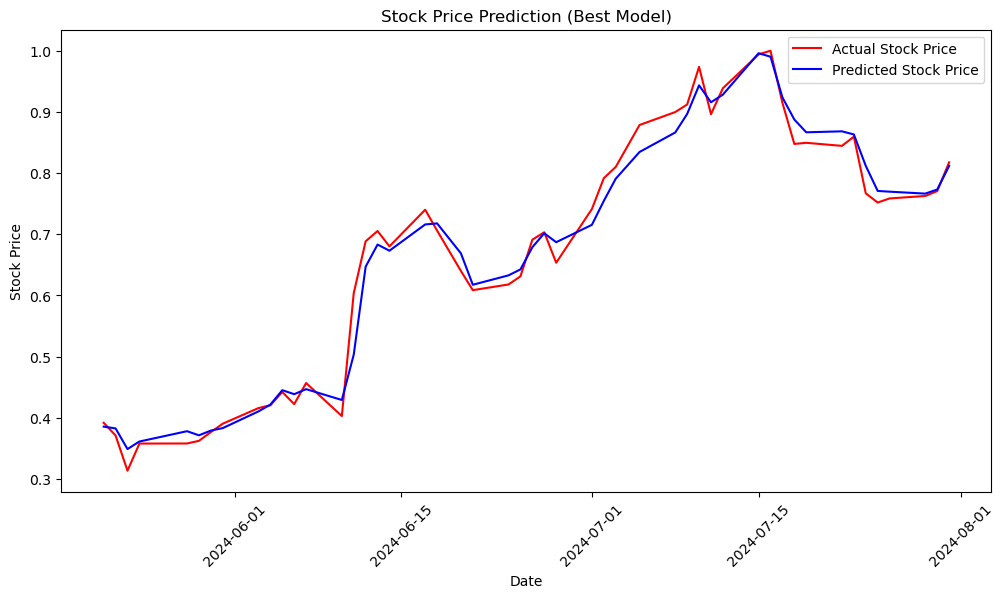

In [10]:
# Define parameters
start_date = "2023-08-01"
end_date = "2024-08-01"
ticker = "AAPL"
company = "AAPL"

# Fetch data
stock_data = fetch_stock_data(ticker, start_date, end_date)
finnhub_client = finnhub.Client(api_key="cqquf8pr01qor5igjm80cqquf8pr01qor5igjm8g")
sentiment_data = fetch_sentiment_data(company, datetime(2023, 8, 1), datetime(2024, 8, 1), finnhub_client)

# Perform sentiment analysis
sentiment_data = perform_sentiment_analysis(sentiment_data)

# Combine data
combined_data = combine_stock_and_sentiment(stock_data, sentiment_data)

# Scale features
combined_data = scale_features(combined_data)

# Prepare data for LSTM
X_train, X_test, y_train, y_test = prepare_lstm_data(combined_data)

# Build, train, and evaluate the LSTM model
best_model, tuner = build_and_train_lstm(X_train, y_train, X_test, y_test)

# Evaluate and plot results
performance_df = evaluate_and_plot(best_model, X_test, y_test, combined_data)


## Conclusion

This notebook demonstrates how to predict stock prices using an LSTM model combined with sentiment analysis from news data. The entire process from data collection to model training and evaluation is covered.
